# Patient Analysis by Sex

This notebook explores `database/metadata.csv` and generates the distribution of patients by sex.

- Reads the CSV and shows an initial summary.
- Converts `SEX` to numeric and handles missing values.
- Deduplicates by `SUBJECT_ID` using the mode (most frequent value) of `SEX`.
- Generates table and bar chart with number of patients by sex.

Note: The dataset encodes sex as 0/1. The exact mapping may vary by database. Below we define a standard dictionary (`0` → `Female`, `1` → `Male`). Adjust if different in your context.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

DATA_PATH = '../../../database/metadata.csv'

In [4]:
# Read CSV
df = pd.read_csv(DATA_PATH)
df.shape, list(df.columns)[:10]

((8971, 20),
 ['SUBJECT_ID',
  'SESSION_ID',
  'CLASS_LABEL',
  'CLASS_LABEL_DETAILED',
  'SEX',
  'AGE',
  'HEIGHT',
  'BODY_WEIGHT',
  'BODY_MASS',
  'SHOE_SIZE'])

In [5]:
# Sample of first rows
df.head()

,SUBJECT_ID,SESSION_ID,CLASS_LABEL,CLASS_LABEL_DETAILED,SEX,AGE,HEIGHT,BODY_WEIGHT,BODY_MASS,SHOE_SIZE,AFFECTED_SIDE,SHOD_CONDITION,ORTHOPEDIC_INSOLE,SPEED,READMISSION,SESSION_TYPE,SESSION_DATE,TRAIN,TRAIN_BALANCED,TEST
0,1,29885,HC,HC,1,18,173.0,516.1,52.6,42.0,NaN,1,0.0,2,0,1,29.01.2015,0,0,1
1,1,29886,HC,HC,1,18,173.0,516.2,52.6,42.0,NaN,1,0.0,1,0,1,29.01.2015,0,0,1
2,1,29888,HC,HC,1,18,173.0,516.1,52.6,42.0,NaN,1,0.0,3,0,1,29.01.2015,0,0,1
3,2,888812549,HC,HC,1,51,182.0,752.1,76.7,44.0,NaN,1,0.0,1,0,1,03.08.2017,1,0,0
4,2,888812550,HC,HC,1,51,182.0,752.4,76.7,44.0,NaN,1,0.0,3,0,1,03.08.2017,1,0,0


## Cleaning and preparing the sex column

In [6]:
# Convert SEX to numeric and handle missing values
df['SEX'] = pd.to_numeric(df['SEX'], errors='coerce')
df_sex = df.dropna(subset=['SEX']).copy()
df_sex['SEX'] = df_sex['SEX'].astype(int)
df_sex[['SUBJECT_ID','SEX']].head()

,SUBJECT_ID,SEX
0,1,1
1,1,1
2,1,1
3,2,1
4,2,1


## One sex category per patient (deduplication)

Since there are multiple sessions per patient, we consolidate `SEX` by `SUBJECT_ID` using the most frequent value (mode).

In [7]:
def mode_or_first(s):
    # Returns the mode; in case of tie, returns the first value
    vc = s.value_counts()
    if vc.empty:
        return np.nan
    top = vc.max()
    candidates = vc[vc == top].index
    return candidates[0]

sex_by_subject = (
    df_sex.groupby('SUBJECT_ID', as_index=False)['SEX'].agg(mode_or_first)
)
sex_by_subject.rename(columns={'SEX': 'SEX_SUBJECT'}, inplace=True)
sex_by_subject.head()

,SUBJECT_ID,SEX_SUBJECT
0,1,1
1,2,1
2,3,1
3,4,0
4,5,0


## Distribution: number of patients by sex

In [8]:
# Label mapping (adjust if necessary)
sex_labels = {0: 'Female', 1: 'Male'}
sex_by_subject['SEX_LABEL'] = sex_by_subject['SEX_SUBJECT'].map(sex_labels).fillna('Unknown')

patients_per_sex = (
    sex_by_subject.groupby(['SEX_SUBJECT','SEX_LABEL'])
    .size()
    .reset_index(name='NUM_PACIENTES')
)
patients_per_sex.sort_values('NUM_PACIENTES', ascending=False).reset_index(drop=True)

,SEX_SUBJECT,SEX_LABEL,NUM_PACIENTES
0,1,Male,1739
1,0,Female,556


In [9]:
# Quick statistics
total_pacientes = len(sex_by_subject)
dist = patients_per_sex[['SEX_LABEL','NUM_PACIENTES']].set_index('SEX_LABEL')['NUM_PACIENTES'].to_dict()
total_pacientes, dist

(2295, {'Female': 556, 'Male': 1739})

## Visualization

/tmp/ipykernel_16754/4028649968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=patients_per_sex, x='SEX_LABEL', y='NUM_PACIENTES', palette=['#ff9999','#99ccff','#cccccc'])
/tmp/ipykernel_16754/4028649968.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=patients_per_sex, x='SEX_LABEL', y='NUM_PACIENTES', palette=['#ff9999','#99ccff','#cccccc'])


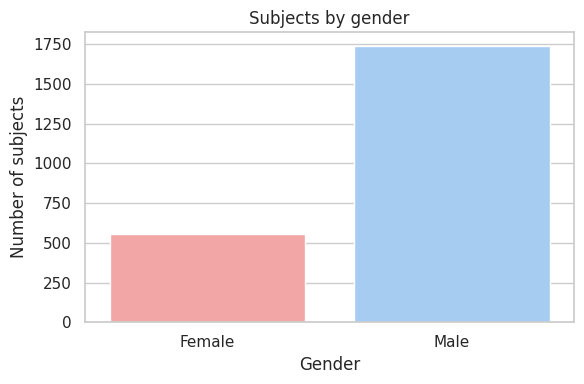

In [10]:
plt.figure(figsize=(6,4))
sns.barplot(data=patients_per_sex, x='SEX_LABEL', y='NUM_PACIENTES', palette=['#ff9999','#99ccff','#cccccc'])
plt.title('Subjects by gender')
plt.xlabel('Gender')
plt.ylabel('Number of subjects')
plt.tight_layout()
plt.show()

## Complete table